In [1]:
import numpy as np
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from Bio import Entrez
from urllib.error import HTTPError,URLError
import textwrap
import time
pd.set_option('display.max_columns', 500)

In [3]:
def swmatrix(a, b, match_score=3, gap_cost=2):
    H = np.zeros((len(a) + 1, len(b) + 1), np.int)
    for i, j in itertools.product(range(1, H.shape[0]), range(1, H.shape[1])):
        match = H[i - 1, j - 1] + (match_score if a[i - 1] == b[j - 1] else - match_score)
        delete = H[i - 1, j] - gap_cost
        insert = H[i, j - 1] - gap_cost
        H[i, j] = max(match, delete, insert, 0)
    return H
def swtraceback(H, b, b_='', old_i=0):
    # flip H to get index of **last** occurrence of H.max() with np.argmax()
    H_flip = np.flip(np.flip(H, 0), 1)
    i_, j_ = np.unravel_index(H_flip.argmax(), H_flip.shape)
    i, j = np.subtract(H.shape, (i_ + 1, j_ + 1))  # (i, j) are **last** indexes of H.max()
    if H[i, j] == 0:
        return b_, j
    b_ = b[j - 1] + '-' + b_ if old_i - i > 1 else b[j - 1] + b_
    return swtraceback(H[0:i, 0:j], b, b_, i)
def smith_waterman(a, b, match_score=3, gap_cost=2):
    a, b = a.upper(), b.upper()
    H = swmatrix(a, b, match_score, gap_cost)
    b_, pos = swtraceback(H, b)
    return pos, pos + len(b_)

In [4]:
s1='FARGNYPAL'
s2 = 'TTFLAHSLDTDK'
smith_waterman(s1,s2)

(2, 4)

In [16]:
Entrez.email ="carloswertcarvajal@gmail.com"
IEDB = pd.read_csv('/Volumes/Maxtor/h2kball1.csv')
IEDB2 = pd.read_csv('/Volumes/Maxtor/h2kball2.csv')
IEDB = pd.concat([IEDB,IEDB2],ignore_index=True,sort=True)
IEDB = IEDB[['Epitope.2','Epitope.8','Assay.4']]
IEDB = IEDB[~(IEDB['Assay.4']=='Negative')]
IEDB = IEDB.drop_duplicates(subset='Epitope.2')
IEDB = IEDB.dropna(axis=0,subset=['Epitope.8']).reset_index(drop=True)
namprop = IEDB[['Epitope.8']].drop_duplicates(subset='Epitope.8').reset_index(drop=True)
namprop = namprop.drop(list(range(0,4089))).reset_index(drop=True)
proteins=pd.DataFrame(columns=['peptides','NB'])
cc=0
window_size = 12
for index, row in namprop.iterrows():
    errorch = 0
    if index == 0:
        pass
    else:
        line = row['Epitope.8']
        print(index,line)
        try:
            handle = Entrez.efetch(db="protein", id=line, retmode="xml")
        except HTTPError:
            time.sleep(20)
            try:
                handle = Entrez.efetch(db="protein", id=line, retmode="xml")
            except HTTPError:
                errorch = 1
                print('Protein '+line+' not found')
        except URLError:
            time.sleep(20)
            handle = Entrez.efetch(db="protein", id=line, retmode="xml")
        if errorch == 1:
            pass
        else:
            records = Entrez.read(handle)
            time.sleep(1) # to make sure not many requests go per second to ncbi
            orig = records[0]["GBSeq_sequence"].upper()
            s2 = orig
            peptss = IEDB[IEDB['Epitope.8']==line].reset_index(drop=True)
            peptss = peptss.drop_duplicates(subset='Epitope.2').reset_index(drop=True)
            for index, row in peptss.iterrows():
                s1 = row['Epitope.2']
                p1, p2 = smith_waterman(s1,s2)
                pos1, pos2 = smith_waterman(s1,orig)
                ctr = int(np.round(np.mean([pos1,pos2])))
                cc=cc+1
                proteins.loc[cc]=[orig[ctr-int(window_size/2):ctr+int(window_size/2)],int(1)]
                s2 = s2[:p1] + s2[p2+1:]
            peps = textwrap.wrap(s2,window_size)
            for n in range (0,len(peps)-1):
                cc=cc+1
                proteins.loc[cc]=[peps[n],int(0)]
proteins = proteins.drop_duplicates(subset='peptides')
proteins.to_csv("/Volumes/Maxtor/windowpeptides7.csv",index=False)

1 Q9WTM5
2 Q80XS6
3 Q60974
4 Q9CU65
5 Q8BGZ2
6 Q8R0X7
7 Q91Y57
8 Q62383
9 Q8K4J0
10 Q9EQ32
11 P48299
12 E9Q7E5
Protein E9Q7E5 not found
13 J3QMN6
Protein J3QMN6 not found
14 P39087
15 Q9D0I9
16 Q9D3B1
17 Q24JP3
18 Q5NCC9
19 P49442
20 Q60973
21 Q9WTL2
22 Q9EQW7
23 Q6A051
24 P51949
25 Q8BKU8
26 P70170
27 P54841
28 Q80UZ0
29 P70325
30 Q8R207
31 Q7TN75
32 Q91WG1
33 D6RHA3
Protein D6RHA3 not found
34 P60335
35 E9Q8B5
Protein E9Q8B5 not found
36 O09012
37 Q8BXQ8
38 F8VQ79
Protein F8VQ79 not found
39 Q80UY2
40 Q9D3G9
41 Q8BYM5
42 Q0VG85
43 Q62136
44 Q80U44
45 Q61474
46 Q9JLV6
47 Q9JJ80
48 Q9Z1S8
49 Q9D4H4
50 Q3U4B1
51 Q03145
52 P03314
53 Q76NM2
54 P9WPE5
55 P9WPE7
56 P17366
57 P04300
58 P24757
59 K4ED23
Protein K4ED23 not found
60 K4E869
Protein K4E869 not found
61 K4E901
Protein K4E901 not found
62 209976837
63 P30672
64 Q9RB65
65 P27542
66 Q7VQ47
67 Q9Z7W9
68 K9L3Y9
Protein K9L3Y9 not found
69 A2T3T0
70 Q6WBA1
71 Q06A28
72 A2T3P5
73 A2T3S5
74 9629585
75 209976844
76 9629569
77 9629558
78 96

In [102]:
hola = textwrap.wrap("123456789", 2)
print(hola)
#1126

['12', '34', '56', '78', '9']


In [14]:
print(proteins)
proteins = proteins.drop_duplicates(subset='peptides')
proteins.to_csv("/Volumes/Maxtor/windowpeptides7.csv",index=False)

           peptides NB
1      FQINVFFYTVPL  1
2      MAAPLALVLVVA  0
3      VTVRAALFRSSL  0
4      AEFISERVEVVS  0
5      PLSSWKRVVEGL  0
6      ALLDLGVSPYSG  0
7      AVFHETPLIIYL  0
8      FHFLIDYAELVF  0
9      MITDALTAIALY  0
10     FAIQDFNKVVFK  0
11     KQKLLLELDQYA  0
12     PDVAELIRTPME  0
13     MRYIPLKVALYL  0
14     LNPYTILSCVAK  0
15     STCAINNTLIAF  0
16     FILTTIKGSVFL  0
17     SAVFLALATYQS  0
18     LYPVTLFAPGLL  0
19     YLLQRQYIPVKV  0
20     KSKAFWIFSWEY  0
21     AMMYTGSLVVIV  0
22     CLSFFLLSSWDF  0
23     IPAVYGFILSVP  0
24     DLTPNIGLFWYF  0
25     FAEMFEHFSLFF  0
26     VCVFQLAIKLKE  0
27     HPIFFMFIQIAI  0
28     ISIFKSYPTVGD  0
29     VALYMAFFPVWN  0
30     HLYRFLRNIFVL  0
...             ... ..
76315  MGNIGRQLAMYE  0
76316  AYSIQGQHTISP  1
76317  MDAGVTESGLNV  0
76318  TLTIRLLMHGKE  0
76319  VGSIIGKKGESV  0
76320  KRIREESGARIN  0
76321  ISEGNCPERIIT  0
76322  LTGPTNAIFKAF  0
76323  AMIIDKLEEDIN  0
76324  SSMTNSTAASRP  0
76325  PVTLRLVVPATQ  0
76326  CGSL

In [54]:
print(IEDB.loc[1,'Epitope.2'])

TRVAFAGL


In [15]:
print(1388+474+458+293+259+1217)

4089


In [21]:
IEDB = pd.read_csv('/Volumes/Maxtor/h2kball1.csv')
IEDB2 = pd.read_csv('/Volumes/Maxtor/h2kball2.csv')
IEDB = pd.concat([IEDB,IEDB2],ignore_index=True,sort=True)
IEDB = IEDB[['Epitope.2','Epitope.8','Assay.4']]
IEDB = IEDB[~(IEDB['Assay.4']=='Negative')]
IEDB = IEDB.drop_duplicates(subset='Epitope.2')
IEDB = IEDB.dropna(axis=0,subset=['Epitope.8']).reset_index(drop=True)
namprop = IEDB[['Epitope.8']].drop_duplicates(subset='Epitope.8').reset_index(drop=True)
#namprop = namprop.drop(list(range(132,180))).reset_index(drop=True)
#Q99JY0
print(namprop[namprop['Epitope.8']=='Q7ARG3'])

     Epitope.8
4349    Q7ARG3


In [94]:
namprop = IEDB[['Epitope.8']].drop_duplicates(subset='Epitope.8').reset_index(drop=True)
namprop = namprop.drop(list(range(132,180))).reset_index(drop=True)
print(namprop.loc[200:230])

    Epitope.8
200    Q9D902
201    P58749
202    Q8K4I3
203    O88845
204    P43247
205    Q8CH77
206    E9PVP1
207    P47753
208    Q99L48
209    Q8R574
210    Q9JHF5
211    Q8K4Z5
212    P62245
213    Q3UFY0
214    Q920Q4
215    Q91YE5
216    Q3UHQ6
217    P40201
218    Q8BH79
219    Q8BHK1
220    Q80W47
221    Q64343
222    P15307
223    Q9ERE3
224    Q91XB7
225    P28867
226    Q8C4B4
227    Q9CZM2
228    Q9CPV7
229    Q09014
230    Q6NS46


In [38]:
pt1 = pd.read_csv('/Volumes/Maxtor/windowpeptides1.csv')
pt2 = pd.read_csv('/Volumes/Maxtor/windowpeptides2.csv')
pt3 = pd.read_csv('/Volumes/Maxtor/windowpeptides3.csv')
pt4 = pd.read_csv('/Volumes/Maxtor/windowpeptides4.csv')
pt5 = pd.read_csv('/Volumes/Maxtor/windowpeptides5.csv')
pt6 = pd.read_csv('/Volumes/Maxtor/windowpeptides6.csv')
pt7 = pd.read_csv('/Volumes/Maxtor/windowpeptides7.csv')
pt = pd.concat([pt1,pt2,pt3,pt4,pt5,pt6,pt7],ignore_index=True)
pt = pt.drop_duplicates(subset='peptides')
indexes_to_drop = []
for index,row in pt.iterrows():
    if type(row['peptides'])==float:
        indexes_to_drop.append(index)
    elif len(row['peptides'])<12:
        indexes_to_drop.append(index)
    else:
        pass
pt = pt.drop(indexes_to_drop)
np.random.seed(123)
pt = pt.sample(frac=1).reset_index(drop=True)
print(pt)
negg = len(pt[pt['NB']==0])
poss = len(pt[pt['NB']==1])
total = negg+poss
print(negg/total)
strings = pt['peptides']
pt.to_csv("/Volumes/Maxtor/4train.csv",index=False)

            peptides  NB
0       EYAAEYEAGVEE   0
1       NTKGLHHLQLIL   1
2       SLSKRKLELEVE   0
3       PVLDCSIADCLH   0
4       TERFGQGGAGPV   0
5       RLKDGVLAYARV   0
6       EGVQLFGLLNFY   0
7       LLVGNYMNSGSR   0
8       DVDESTLSPEEQ   0
9       VCVPACPPGTYR   0
10      ERPGLSLTQDVL   0
11      YMLPLDNLKIRD   0
12      PMRGMSNNTPQL   0
13      VHHAKTTKPQAQ   0
14      IKALSKDLPKVV   0
15      PLPHRDRDRDRE   0
16      SLLSKKHNKVLE   0
17      LSQKEQAAEHYK   0
18      SRAEGYEKTDDV   0
19      RVIEVVQGACRA   0
20      MTYEWYLPKMAR   0
21      SKEKDRQSPLHG   0
22      NINHPDIRLKQL   0
23      TGSSHERFLSFS   0
24      TLKREGVCAASL   0
25      LSNPCLKKENTE   0
26      QRMDVFYLQPEC   0
27      RIPDGEAGFSKS   0
28      QKTSSSSPLSSP   0
29      VVRGVDWQWEDQ   0
...              ...  ..
251019  SLSIYSIWFYDK   0
251020  TTNEYDGHTTYP   0
251021  IGADVSHLNLHK   0
251022  NVQGELSAYASV   0
251023  TATLGRRLVNIT   0
251024  LTRPCSPQNKIS   0
251025  LQHFIYMKVNIA   0
251026  ALRKSACRVFAM   0


In [28]:
Neg1 = pd.read_csv('/Volumes/Maxtor/realnegatives.csv')
print(Neg1)

             peptides  NB
0       MKVKVLSLLVPAL   0
1       LVAGAANAAEIYN   0
2       KDGNKLDLFGKVD   0
3       GLHYFSDDKGSDG   0
4       DQTYMRIGFKGET   0
5       QVNDQLTGYGQWE   0
6       YQIQGNQTEGSND   0
7       SWFADAGSFDYGR   0
8       NYGVTYDVTSWTD   0
9       VLPEFGGDTYGAD   0
10      NFMQQRGNGYATY   0
11      DGLDFALQYQGKN   0
12      GSVSGENTNGRSL   0
13      LNQNGDGYGGSLT   0
14      YAIGEGFSVGGAI   0
15      TTSKRTADQNNTA   0
16      NARLYGNGDRATV   0
17      YTGGLKYDANNIY   0
18      LAAQYSQTYNATR   0
19      FGTSNGSNPSTSY   0
20      GFANKAQNFEVVA   0
21      QYQFDFGLRPSVA   0
22      YLQSKGKDISNGY   0
23      GASYGDQDIVKYV   0
24      DVGATYYFNKNMS   0
25      TYVDYKINLLDKN   0
26      DFTRDAGINTDDI   0
27      MADSHNTQYCSLQ   0
28      ESAQAQQELDNDQ   0
29      ETMETSEEEEDTT   0
...               ...  ..
224638  VDSMKKIIFYSHA   0
224639  AEKYPADITAYLN   0
224640  VADDCQYFSGEWD   0
224641  STLPKERQIEIEK   0
224642  KVNVTCSKARSLQ   0
224643  EKLSVKYKKRQDL   0
224644  MKNR

In [52]:
IEDB = pd.read_csv('/Volumes/Maxtor/secondtrain.csv')
Neg1 = pd.read_csv('/Volumes/Maxtor/realnegatives.csv')
Neg1 = Neg1.sample(frac=0.3).reset_index(drop=True)
allp = pd.concat([IEDB,Neg1],ignore_index=True,sort=True)
allp = allp[['peptides','NB']]
allp = allp.sample(frac=1).reset_index(drop=True)


In [53]:
negg = len(allp[allp['NB']==0])
poss = len(allp[allp['NB']==1])
total = negg+poss
print(negg/total)

0.9010762107370792


In [54]:
allp.to_csv("/Volumes/Maxtor/thirdtrain.csv",index=False)

In [14]:
IEDB = pd.read_csv('/Volumes/Maxtor/h2kball1.csv')
IEDB2 = pd.read_csv('/Volumes/Maxtor/h2kball2.csv')
IEDB = pd.concat([IEDB,IEDB2],ignore_index=True,sort=True)
IEDB = IEDB[['Epitope.2','Epitope.8','Assay.4']]
IEDB = IEDB[~(IEDB['Assay.4']=='Negative')]
IEDB = IEDB.drop_duplicates(subset='Epitope.2')
IEDB = IEDB.dropna(axis=0,subset=['Epitope.8']).reset_index(drop=True)
strings = IEDB['Epitope.2']
total_avg = sum( map(len, strings) ) / len(strings)
total_max = max(strings, key=len)
total_min = min(strings, key=len)

In [16]:
print(total_avg, len(total_max), len(total_min))

9.48537321264594 36 6


(array([3.327e+03, 3.397e+03, 3.780e+02, 3.160e+02, 1.490e+02, 4.700e+01,
        6.000e+00, 0.000e+00, 1.000e+00, 2.000e+00]),
 array([ 6.,  9., 12., 15., 18., 21., 24., 27., 30., 33., 36.]),
 <a list of 10 Patch objects>)

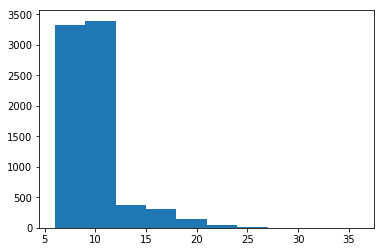

In [19]:
lens = list(map(len, strings))
plt.hist(lens)

In [46]:
s1='LGITYDGMMTD'
s2 = 'MADSHNTQYCSLQESAQAQQELDNDQETMETSEEEEDTTTSNKVYGSGIPSPPQSPQRAYSPCVALASIPDSPSEEASIKGSGGLEDPLYLLHNAQNTKVYDLVDFLVLNYQMKAFTTKAEMLESIGREYEEYYPLIFSEASECLKMVFGLDMVEVDPSVHSYILVTALGITYDGMMTDVLGMPKTGILIAVLSVIFMKGNYVSEEIIWEMVNNIGLCGGRDPYIHKDPRKLISEEFVQEGCLKYRQVPNSDPPSYGFLWGPRAFAETSKMKVLQFFASINKTHPRAYPEKYAEALQDEIDRTKAWILNRCSNSSDLLTF'

p1,p2 = smith_waterman(s1,s2)
ctr = int(np.round(np.mean([p1,p2])))
window = 14
print(s2[ctr-int(window/2):ctr+int(window/2)])
print(len(s2[ctr-int(window/2):ctr+int(window/2)]))

ALGITYDGMMTDVL
14


In [29]:
ctr = np.mean([p1,p2])
print(ctr)

172.0


In [45]:
IEDB = pd.read_csv('/Volumes/Maxtor/h2kball1.csv')
IEDB2 = pd.read_csv('/Volumes/Maxtor/h2kball2.csv')
IEDB = pd.concat([IEDB,IEDB2],ignore_index=True,sort=True)
IEDB = IEDB[['Epitope.2','Assay.4']]
opos = IEDB[~(IEDB['Assay.4']=='Negative')]
opos_f = pd.DataFrame(columns=['peptides','NB'])
cc = 0
window_size = 14
for index, row in opos.iterrows():
    if index==0:
        pass
    else:
        if len(row['Epitope.2'])>=14:
                orig = row['Epitope.2']
                ctr = int(np.round((len(row['Epitope.2'])-1)/2))
                cc=cc+1
                opos_f.loc[cc]=[orig[ctr-int(window_size/2):ctr+int(window_size/2)],int(1)]

In [46]:
print(opos_f)

           peptides NB
1    IRGTKVSPRGKLST  1
2    EFNIIS + AMID(  1
3    QYVYGR + AMID(  1
4    CKISPLMVAYMLER  1
5    DSGPSNTPPEIHPV  1
6    FIRGTKVSPRGKLS  1
7    TRDVLNLYADFIAS  1
8    AHSMQRHLRRLGRT  1
9    TRDVLDLFADFIAS  1
10   TRDVLNLFADFIAS  1
11   TRDVLQLFADFIAS  1
12   VYNFATM + MCM(  1
13   YVYQGL + GLYC(  1
14   CQIFANI + ABA(  1
15   CYIFANI + ABA(  1
16   GFFAMNHQNQWQWT  1
17   LLELCKLPTFLGNP  1
18   GLNSSFNFTAPFIS  1
19   PFISPTHYRQTSYT  1
20   RWVRSGGANGANFP  1
21   ANFPLMTKQDYAFL  1
22   GQAEPDRAHYNIVT  1
23   QAEPDRAHYNIVTF  1
24   RAHYNIVTFCCKCD  1
25   AHYNIVTFCCKCDS  1
26   HYNIVTFCCKCDST  1
27   YNIVTFCCKCDSTL  1
28   NIVTFCCKCDSTLR  1
29   KCDSTLRLCVQSTH  1
30   CDSTLRLCVQSTHV  1
..              ... ..
853  ISSPPMFRVPVNPV  1
854  ISSPPMFRVPVNPV  1
855  ISSPPMFRVPVNPV  1
856  ISSPPMFRVPVNPV  1
857  ISSPPMFRVPVNPV  1
858  ISSPPMFRVPVNPV  1
859  ISSPPMFRVPVNPV  1
860  ISSPPMFRVPVNPV  1
861  SRKYPARALEYKNL  1
862  SRKYPARALEYKNL  1
863  SRKYPARALEYKNL  1
864  SRKYPA

In [ ]:
pti = pd.read_csv("/Volumes/Maxtor/4train.csv")
strings = pti['peptides']
total_avg = sum( map(len, strings) ) / len(strings)
total_max = max(strings, key=len)
total_min = min(strings, key=len)
print(total_avg,total_max,total_min)

In [11]:
type(12)==int

True

In [18]:
print(len(pt.loc[4217,'peptides']))

12


In [12]:
Entrez.email ="carloswertcarvajal@gmail.com"
IEDB = pd.read_csv('/Volumes/Maxtor/h2kball1.csv')
IEDB2 = pd.read_csv('/Volumes/Maxtor/h2kball2.csv')
IEDB = pd.concat([IEDB,IEDB2],ignore_index=True,sort=True)
IEDB = IEDB[['Epitope.2','Epitope.8','Assay.4']]
#IEDB = IEDB[~(IEDB['Assay.4']=='Negative')]
IEDB = IEDB.drop_duplicates(subset='Epitope.2')
#IEDB = IEDB.dropna(axis=0,subset=['Epitope.8']).reset_index(drop=True)
namprop = IEDB[['Epitope.8']].drop_duplicates(subset='Epitope.8').reset_index(drop=True)
#namprop = namprop.drop(list(range(0,4089))).reset_index(drop=True)

In [13]:
print(namprop)

                     Epitope.8
0     Parent Protein Accession
1                       P0A263
2                       Q9R2A2
3                       P10211
4                       P24770
5                       P68714
6                       P26673
7                       P03431
8                       Q6T340
9                          NaN
10                      P03508
11                      P09991
12                      O57286
13                      P03466
14                      P09992
15                      P03496
16                      P03452
17                      P01012
18                      P03485
19                      P03254
20                      P03468
21                      P03428
22                      P03433
23                      Q76R62
24                      P06821
25                      P0C0U1
26                      P21171
27                      P23224
28                      P13128
29                      Q1BSK9
...                        ...
4799    

In [2]:
pti = pd.read_csv("/Volumes/Maxtor/4train.csv")

In [9]:
print(len(pti[pti['NB']==1]))
print(len(pti[pti['NB']==0]))

6714
244335
